<a href="https://colab.research.google.com/github/gmauricio-toledo/NLP-MCD/blob/main/04-N-gramas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Modelos de lenguaje: $N$-gramas

Usaremos el corpus Reuters para entrenar un primer modelo de lenguaje. Este modelo lo usaremos para predicir la siguiente palabra en una secuencia de palabras dada.

El Corpus Reuters contiene 10,788 documentos de noticias con un total de 1.3 millones de palabras. Los documentos se han clasificado en 90 temas y agrupado en dos conjuntos, *train* y *test*.

* Corpus en NLTK: https://www.nltk.org/howto/corpus.html

In [1]:
import nltk
from nltk import bigrams, trigrams
from nltk.corpus import reuters
from collections import defaultdict
from string import punctuation

In [2]:
nltk.download('reuters')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## 3-gramas

### Exploración del corpus

Es importante explorar y conocer los corpus. Al entrenar nuestros modelos podemos necesitar corpora con caracteristicas particulares.

Exploremos un poco el corpus. Veamos el inicio del corpus

In [ ]:
' '.join(reuters.words()[:15])

Podemos acceder a los *ids* de los archivos.

In [ ]:
reuters.fileids()[:5]

Podemos obtener el tema de cada archivo

In [ ]:
reuters.categories('test/14826')

In [ ]:
fileids = reuters.fileids()

for fileid in fileids[:5]:
    print(reuters.categories(fileid))
    print(reuters.raw(fileid)[:200],end="...\n\n")

Podemos ver los documentos que tienen que ver con un tema

In [ ]:
reuters.fileids('corn')[:10]

### Crear el modelo de lenguaje

Tokenizamos el texto usando NLTK

In [3]:
words = nltk.word_tokenize(' '.join(reuters.words()))

También podríamos tokenizar el texto quitando signos de puntuación.

In [4]:
punctuations = list(punctuation)

words = [t for t in nltk.word_tokenize(' '.join(reuters.words())) if t not in punctuations]

Extraemos los trigramas

https://www.nltk.org/api/nltk.util.html#nltk.util.trigrams

In [5]:
tri_grams = list(trigrams(words))

Veamos los primero trigramas

In [ ]:
print(tri_grams[:10])

Realicemos los conteos. Los almacenamos en un diccionario donde cada llave es un par (las primeras dos palabras del trigrama) y el valor es un diccionario con el conteo de cada tercer palabra.

Usamos un [`defaultdict`](https://docs.python.org/3/library/collections.html#collections.defaultdict) para almacenar estos conteos. En caso de que una tripleta no exista, tendremos el valor 0.

In [ ]:
model = defaultdict(lambda: defaultdict(lambda: 0)) # Valor por defecto si el trigrama no existe
print(model)

for w1, w2, w3 in tri_grams:
    model[(w1, w2)][w3] += 1
    break

model

Veamos cómo se ve este diccionario:

In [ ]:
model[('ASIAN','EXPORTERS')]

In [ ]:
model[('ASIAN','EXPORTERS')]['FEAR']

En caso de que no exista el trigrama con la tercera palabra:

In [ ]:
model[('ASIAN','EXPORTERS')]['UNIVERSITY']

En caso de que no exista el trigrama con la pareja de las primeras dos palabras

In [ ]:
model[('STATE','OF')]

Ahora sí generamos todos los conteos

In [6]:
model = defaultdict(lambda: defaultdict(lambda: 0)) # Valor por defecto si el trigrama no existe

for w1, w2, w3 in tri_grams:
    model[(w1, w2)][w3] += 1

In [ ]:
print(model[('STATE','OF')]['THE'])
print(model[('ASIAN','EXPORTERS')]['FEAR'])

Para entender cómo funciona la función siguiente, veamos que, en caso de no existir el trigrama podemos tratarlo como un booleano.

Transformamos los conteos en probabilidades

In [7]:
for w1_w2 in model:
    total_count = float(sum(model[w1_w2].values()))
    for w3 in model[w1_w2]:
        model[w1_w2][w3] /= total_count

Veamos un ejemplo:

In [ ]:
model[('given','that')]

In [ ]:
# Para un trigrama que no exista
v = model[('DREAM','ABOUT')]  # diccionario con las posibles combinaciones de cada tercer palabra con las primeras dos
print(v)
if v:
    print("True")
else:
    print("False")

# Para un trigrama que sí exista
v = model['ASIAN','EXPORTERS']
print(v)
if v:
    print("True")
else:
    print("False")

### Probemos el modelo en varias tareas:

Función que calcula la próxima palabra basada en dos palabras anteriores

In [8]:
def predict_next_word(w1, w2):
    next_word = model[w1, w2]  # El diccionario de la probabilidad de cada 3er palabra
    if next_word:
        predicted_word = max(next_word, key=next_word.get)  # Obtener la palabra más probable
        return predicted_word
    else:
        return "SIN PREDICCIÓN"

In [9]:
print(f"Siguiente palabra para 'the'-'stock': '{predict_next_word('the', 'stock')}'")

Siguiente palabra para 'the'-'stock': 'of'


In [ ]:
text = "the state of"
# text = "ASIAN EXPORTERS FEAR DAMAGE"
# text = "We are considering"
# text = "Given the current"

w0 = text.split()[-2]
w1 = text.split()[-1]
print(f"Siguiente palabra para '{w0}'-'{w1}': '{predict_next_word(text.split()[-2], text.split()[-1])}'")

In [ ]:
import string

punctuations = list(string.punctuation)

def evaluar(text,model):
    tokenized_text = [t for t in nltk.word_tokenize(text) if t not in punctuations]
    aciertos = 0
    for j,t in enumerate(tokenized_text):
        if j != 0 and j<len(tokenized_text)-1:
            previous_word = tokenized_text[j-1]
            this_word = t
            next_word = tokenized_text[j+1]
            print(f"Predicción para '{previous_word}'-'{this_word}': '{predict_next_word(previous_word, this_word)}'. Debería ser: '{next_word}'")
            if predict_next_word(previous_word, this_word) == next_word:
                aciertos += 1
    print(f"\nAciertos: {aciertos}/{len(tokenized_text)-2} = {round(100*aciertos/(len(tokenized_text)-2),2)}%")

Probemos con un texto pequeño.

In [ ]:
from nltk.corpus import stopwords

text = "The Ottomans kept them as guardians of the strategic Via Maris and Damascus–Jerusalem highways and rewarded them with tax farms"

evaluar(text,model)

Probemos con un texto más grande:

---

Norwich Market (also known as Norwich Provision Market) is an outdoor market consisting of around 200 stalls in central Norwich, England. Founded in the latter part of the 11th century to supply Norman merchants and settlers moving to the area following the Norman conquest of England, it replaced an earlier market a short distance away. It has been in operation on the present site for over 900 years.

By the 14th century, Norwich was one of the largest and most prosperous cities in England, and Norwich Market was a major trading hub. Control of, and income from, the market was ceded by the monarchy to the city of Norwich in 1341, from which time it provided a significant source of income for the local council. Freed from royal control, the market was reorganised to benefit the city as much as possible. Norwich and the surrounding region were devastated by plague and famine in the latter half of the 14th century, with the population falling by over 50%. Following the plague years, Norwich came under the control of local merchants and the economy was rebuilt. In the early 15th century, a Guildhall was built next to the market to serve as a centre for local government and law enforcement. The largest surviving mediaeval civic building in Britain outside London, it remained the seat of local government until 1938 and in use as a law court until 1985.

---

In [ ]:
text = '''Norwich Market (also known as Norwich Provision Market) is an outdoor market consisting of around 200 stalls in central Norwich, England. Founded in the latter part of the 11th century to supply Norman merchants and settlers moving to the area following the Norman conquest of England, it replaced an earlier market a short distance away. It has been in operation on the present site for over 900 years.

By the 14th century, Norwich was one of the largest and most prosperous cities in England, and Norwich Market was a major trading hub. Control of, and income from, the market was ceded by the monarchy to the city of Norwich in 1341, from which time it provided a significant source of income for the local council. Freed from royal control, the market was reorganised to benefit the city as much as possible. Norwich and the surrounding region were devastated by plague and famine in the latter half of the 14th century, with the population falling by over 50%. Following the plague years, Norwich came under the control of local merchants and the economy was rebuilt. In the early 15th century, a Guildhall was built next to the market to serve as a centre for local government and law enforcement. The largest surviving mediaeval civic building in Britain outside London, it remained the seat of local government until 1938 and in use as a law court until 1985. '''

evaluar(text,model)

Probemos con un texto del mismo corpus:

In [ ]:
text = reuters.raw('test/14826')
# text = reuters.raw('test/14828')

evaluar(text,model)

Predicción para 'ASIAN'-'EXPORTERS': 'FEAR'. Debería ser: 'FEAR'
Predicción para 'EXPORTERS'-'FEAR': 'DAMAGE'. Debería ser: 'DAMAGE'
Predicción para 'FEAR'-'DAMAGE': 'FROM'. Debería ser: 'FROM'
Predicción para 'DAMAGE'-'FROM': 'U'. Debería ser: 'U.S.-JAPAN'
Predicción para 'FROM'-'U.S.-JAPAN': 'SIN PREDICCIÓN'. Debería ser: 'RIFT'
Predicción para 'U.S.-JAPAN'-'RIFT': 'SIN PREDICCIÓN'. Debería ser: 'Mounting'
Predicción para 'RIFT'-'Mounting': 'trade'. Debería ser: 'trade'
Predicción para 'Mounting'-'trade': 'friction'. Debería ser: 'friction'
Predicción para 'trade'-'friction': 'and'. Debería ser: 'between'
Predicción para 'friction'-'between': 'the'. Debería ser: 'the'
Predicción para 'between'-'the': 'two'. Debería ser: 'U.S.'
Predicción para 'the'-'U.S.': 'SIN PREDICCIÓN'. Debería ser: 'And'
Predicción para 'U.S.'-'And': 'SIN PREDICCIÓN'. Debería ser: 'Japan'
Predicción para 'And'-'Japan': 'will'. Debería ser: 'has'
Predicción para 'Japan'-'has': 'the'. Debería ser: 'raised'
Predicc

⭕ Preguntas para reflexionar:

* ¿Qué efecto tiene el tipo de corpus en la construcción y desempeño del modelo?
* ¿Qué podríamos hacer para incrementar los aciertos?

⭕ Realicemos una nube de palabras con los trigramas, ¿con o sin stopwords?

In [6]:
!pip install -qq wordcloud

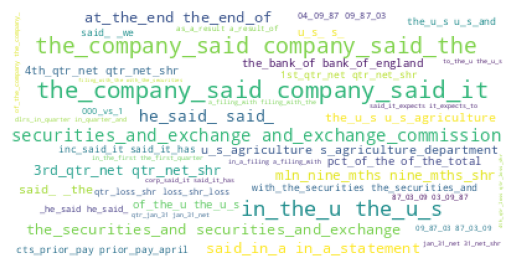

In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

tgs = [f"{w1}_{w2}_{w3}".lower() for w1,w2,w3 in tri_grams]

wc = WordCloud(background_color='white')
wc.generate(" ".join(tgs))
plt.imshow(wc)
plt.axis('off')
plt.show()

Ahora, generemos automáticamente algunas palabras con este modelo:

In [22]:
vocab = list(set(list(reuters.words()))) # El vocabulario

In [30]:
import numpy as np

word_pair = list(model.keys())[94]

# random_idx = np.random.randint(0, len(vocab))
# word_pair = list(model.keys())[random_idx]

print(word_pair)

('Has', 'said')


In [31]:
total_len = 25  # longitud del texto generado

pos = 0
print(word_pair[0],word_pair[1],end=' ')
while pos<total_len:
    next_word = predict_next_word(word_pair[0], word_pair[1])
    print(next_word, end=' ')
    word_pair = (word_pair[1], next_word)
    pos += 1

Has said it has agreed to sell its lt Delhi Petroleum Pty Ltd said it has agreed to sell its lt Delhi Petroleum Pty Ltd said it 

⭕ Preguntas:

* ¿Qué tanto sentido tiene el texto?
* ¿Cómo podemos evaluar estas tareas?

## Unigramas

⭕ ¿Cómo serían las predicciones con un modelo de unigramas?

In [ ]:
from collections import Counter

conteos = Counter(list(reuters.words()))
print(conteos)

## Ejercicios - Tarea 2

⭕ Repetir el experimento con 2-gramas, 4-gramas y 2-skip-2-gramas.

En cada uno de ellos:

* Generar el modelo de $n$-gramas (con y sin signos de puntuación).
* Realizar el experimento de predecir la siguiente palabra con el texto. Evaluar el experimento.
* Realizar una generación de texto comenzando en dos diferentes *seeds*.

⭕ Discutir y redactar un reporte (en el mismo notebook) abordando los siguientes puntos:

1. ¿Qué modelo de los 6 logró mejores predicciones?
2. ¿Qué modelo de los 6 tenía más problemas generando predicciones?
3. ¿Qué efecto tiene el tipo de corpus en la construcción y desempeño del modelo?
4. ¿Qué podríamos hacer para incrementar los aciertos?

## Generalizaciones de $n$-gramas

### Skipgrams

Un $k$-skip-$n$-gram es una subsecuencia de longitud $n$ en la que los tokens aparecen a una distancia $k$ como máximo entre sí.


https://www.nltk.org/api/nltk.util.html

In [11]:
from nltk.util import skipgrams

text = "The rain in Spain falls mainly on the plain"

tokenized_text = [t for t in nltk.word_tokenize(text) if t not in punctuations]

skip_grams = list(skipgrams(tokenized_text, 2, 1))
print(skip_grams)

[('The', 'rain'), ('The', 'in'), ('rain', 'in'), ('rain', 'Spain'), ('in', 'Spain'), ('in', 'falls'), ('Spain', 'falls'), ('Spain', 'mainly'), ('falls', 'mainly'), ('falls', 'on'), ('mainly', 'on'), ('mainly', 'the'), ('on', 'the'), ('on', 'plain'), ('the', 'plain')]


### Syntactic n-grams

https://www.cic.ipn.mx/~sidorov/#sn-grams